# Inferring the history of random recursive trees

In [3]:
import sys
from scipy import sqrt
from statistics import variance, mean 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
import scipy.sparse.linalg
import scipy.linalg

## Functions to save and load results of experiments

In [6]:
import pickle
 
class MyClass():
    def __init__(self, param):
        self.param = param
 
def save_object(obj,name):
    try:
        with open(name+".pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
        
def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

## Sampling of graphs

Sample the adjacency matrix of URRT and PA trees.

In [7]:
def URRT(n): # give the adjacency matrix of a URRT
    M=np.zeros((n,n))
    for i in range(2,n+1):
        j=np.random.randint(1,i)
        M[j-1,i-1]+=1
    return M+np.transpose(M)

def URRT_List(n): # gives the adjacency lisy of a tree
    L=[{1,2}]
    for i in range(3,n+1):
        j=np.random.randint(1,i)
        L.append({j,i})
    return L

def PA(n):                       #return the adjacency matrix of a PA tree
    M=np.zeros((n,n))
    M[0,1]=1     #we start by an edge
    connect=[1,2] #list of picked vertices, useful for PA (its like counting degree)
    for i in range(3,n+1):
        j=np.random.randint(2*(i-2))
        connect.append(i)
        connect.append(connect[j])
        M[connect[j]-1,i-1]+=1
    return M+np.transpose(M)

Sample an URRT or PA and during the sampling save the descendants of every vertex.

In [8]:
def URRT_subtree(n):  # give the graph of a URRT and a list of the descendents of each vertex
    M=np.zeros((n+1,n+1))
    subtree=[[1]]
    for i in range(2,n+1):
        j=np.random.randint(1,i)
        M[j,i]+=1
        M[i,j]+=1
        subtree.append([i])
        subtree[j-1].append(i)
        for k in range(1,j-1):
            if j in subtree[k]:
                subtree[k-1].append(i)
    return M,subtree

def PA_subtree(n):      # give the graph of a PA and a list of the descendents of each vertex
    M=np.zeros((n,n))
    M[0,1]=1     #we start by an edge
    subtree=[[1,2],[2]]  #list of descendents
    connect=[1,2] #list of picked vertices, useful for PA (its like counting degree)
    for i in range(3,n+1):
        j=np.random.randint(2*(i-2))
        connect.append(i)
        J=connect[j]
        connect.append(J)
        M[J-1,i-1]+=1
        subtree.append([i])
        subtree[J-1].append(i)
        for k in range(1,J-1):
            if J in subtree[k]:
                subtree[k-1].append(i)
    return M+np.transpose(M),subtree

Sample an URRT or PA tree and save the degree of each node during the sample.

In [9]:
def URRTDegree(n):  #return a URRT and the list of degree
    M=np.zeros((n,n))
    D=np.ones(n)
    D[0]=0
    for i in range(2,n+1):
        j=np.random.randint(1,i)
        M[j-1,i-1]+=1
        D[j-1]+=1
    return M+np.transpose(M),D

def PADegree(n):
    M=np.zeros((n,n))
    D=[1,1]  #list of degrees
    M[0,1]=1     #we start by an edge
    connect=[1,2] #list of picked vertices, useful for PA (its like counting degree)
    for i in range(3,n+1):
        j=np.random.randint(2*(i-2))
        connect.append(i)
        J=connect[j]
        connect.append(J)
        M[J-1,i-1]+=1
        D.append(1)
        D[J-1]+=1
    return M+np.transpose(M),D

## Useful functions

The next functions are a very inefficient and naive way to compute the Jordan centrality of nodes in a tree.

In [10]:
def SizeSubtree(M,u,v):  #u is the root, v one of its neighbour.
    n=len(M)
    if np.sum(M[v-1])==1: #v is a leaf
        return 1
    else:
        s=1
        for k in range(1,n+1):
            if M[v-1,k-1]==1:
                if k != u: #on parcourt les voisins qui ne sont pas u
                    s+=SizeSubtree(M,v,k)
        return s



def SizeSubtrees(M,u):
    n=len(M)
    J=[]
    for v in range(1,n+1):
        if M[u-1,v-1]:
            J.append(SizeSubtree(M,u,v))
    return J



def JordanOneNode(M,u):  # Compute the Jordan centrality of a given node
    n=len(M)
    J=0
    for v in range(1,n+1):
        if M[u-1,v-1]:
            j=SizeSubtree(M,u,v)
            if j>J:
                J=j
    return J



def Jordan(M):  #return a list fo the Jordan centrality of all nodes in the tree.
    n=len(M)
    J=[]
    for v in range(1,n+1):
        J.append(JordanOneNode(M,v))
    return J

Then we define two error measures. error2 is the one analyzed in our paper.

In [11]:
def error1(sigma,alpha=1):
    s=0
    i=1
    for order in sigma:
        s+=order/(i**alpha)
        i+=1
    return s

def error2(sigma,alpha=1):
    s=0
    i=1
    for order in sigma:
        s+=abs(order-i)/(i**alpha)
        i+=1
    return s

Then we define our basic ordering procedure.

In [12]:
def ordering(SubTreeList):    #return the descendant ordering. Deal with equality cases by adding noise.
    L=[]
    n=len(SubTreeList)
    i=0
    for SubTree in SubTreeList:   #count number of descendents of each vertex
        L.append((-len(SubTree)-np.random.uniform(-0.5,0.5),i))  #add noise to deal with equality
        i+=1
    L.sort()
    sorted_L,permutation = zip(*L)
    ordering=[]
    for i in range(n):                         #go from permutation to ordering
        ordering.append(permutation.index(i)+1)
    return ordering

In [13]:
def JordanOrdering(M):  #Return the Jordan ordering. This function is highly inefficient.
    J=Jordan(M)
    n=len(J)
    i=0
    L=[]
    for j in J:
        L.append((j+np.random.uniform(-0.5,0.5),i)) #add noise
        i+=1
    L.sort()
    sorted_L,permutation = zip(*L)
    ordering=[]
    for i in range(n):                         #go from permutation to ordering
        ordering.append(permutation.index(i)+1)
    return ordering

The minimax lower bound on the error2 in the URRT and theoretical upper bounds for error2 in the URRT and PA.

In [14]:
def Ralpha(n,alpha):      # the minimax lower bound on the error R2
    return (n**(2-alpha))/65
    
def TheoreticalUpperBound(n,alpha):       
    if alpha==1:
        return (1170)*Ralpha(n,alpha)
    else:
        return Ralpha(n,alpha)*65*(1/(2-alpha)+3/(2-alpha)**2+1/(2-alpha)**3)
    
    
def TheoreticalUpperBoundPA(n,alpha):
    return ((1/(2-alpha))+1/((alpha-1.25)*(alpha-2)))*n**(2-alpha)

Other ordering methods:

In [15]:
def SpectralOrdering(M):
    n=len(M)
    L=np.diag(np.matmul(M,np.ones((n,1)))[:,0])-M   #compute laplacian
    value,vector=scipy.sparse.linalg.eigsh(L, 2, which='SM')    #compute 2 smallest eigenvalues and eigen vectors
    X= list(vector[:,1]) #keep only second smallest eigen vector
    L = [ (X[i],i) for i in range(len(X)) ]  #trick to find the permutation that orders them
    L.sort()
    sorted_L,permutation = zip(*L)
    ordering=[]
    for i in range(n):                         #go from permutation to ordering
        ordering.append(permutation.index(i))
    return ordering

def DegreeOrdering(D):
    n=len(D)
    L=[]
    i=0
    for d in D:
        L.append((-d-np.random.uniform(-0.5,0.5),i))  #we add some noise to deal with degree equalities
        i+=1
    L.sort()
    sorted_L,permutation = zip(*L)
    ordering=[]
    for i in range(n):                         #go from degree to ordering
        ordering.append(permutation.index(i))
    return ordering

The improved degree method ordering, taken from "Network Archaeology: Uncovering Ancient Networks from Present-day Interactions", section 2.3.

In [16]:
def SurvivorSum(L,survivors):  #a function to compute the sum of only some index of a list
    sum=0
    for s in survivors:
        sum+=L[s]
    return sum


def criterium(j,M,N):  #N is number of vertices left in graph, M can be bigger and have lines and columns set to 0
    product=1
    d=len(M)
    p=1
    for i in range(d):
        if M[j,i]==1:   #if i is a neighbour of j
            p*=(sum(M[i])-1)/N  #the minus 1 because it is the degree of i with j removed from the graph
        else:
            p*=1-sum(M[i])/N
    return p

def criteriumBetter(j,M,survivor,N):  #criterium for the matrix after removing everyone except survivors
    product=1
    d=len(M)
    p=1
    for i in survivor:
        if M[j,i]==1:   #if i is a neighbour of j
            p*=(sum(M[i])-1)/N  #the minus 1 because it is the degree of i with j removed from the graph
        else:
            p*=1-sum(M[i])/N
    return p


def ImprovedPeeling(M):
    n=len(M)
    N=n
    Survivors=[k for k in range(n)] #vertices not yet ordered
    sigmainverse=[]
    for i in range(n-2):  #each loop we order one new vertex, until only one edge left
        L=[]             #list of leaves at this step
        for k in Survivors:
            if SurvivorSum(M[k],Survivors)==1:   #meaning k is a leaf at this step
                L.append(k)
        P=0
        J=L[0]
        for j in L: #for leaves, compute which one is most likely the last
            p=criteriumBetter(j,M,Survivors,N)
            if p>P:
                J=j
                P=p
        sigmainverse.append(J+1)
        Survivors.remove(J)
        N=N-1
    for k in Survivors:   #the two last ones can be added in whatever order
        sigmainverse.append(k+1)
    return sigmainverse[::-1]



## Plots of the error2 of the descendant ordering

URRT case:

In [17]:
alpha=1 # parameter of the error
alphaB=1.5  #second alpha in thesimulation
n0=50 #initial size of the graph
n=201 #max size of the graph
#step=100 #do not look at all sizes, but go with big steps
k=2 #number of experience for each size

In [63]:
R2=[]   # list of estimated error2
X=[]     # list of sizes of graph that we tried

R2B=[]   # list of estimated error2 for alphaB
XB=[]     # list of sizes of graph that we tried for alphaB

i=n0
while i <n: #exponential steps
#for i in range(n0,n,step): #linear steps
    X.append(i)
    r2=[]
    r2B=[]
    for j in range(k):     # we do k experiments at each size
        M,ST=URRT_subtree(i)   # we sample a URRT and the list of descendents of each vertex
        Ordering=ordering(ST)
        r2.append(error2(Ordering,alpha))
        r2B.append(error2(Ordering,alphaB))
    R2.append(r2)
    R2B.append(r2B)
    i=int(2*i) # update i

save_object([R2,R2B,X],"URRT_error")

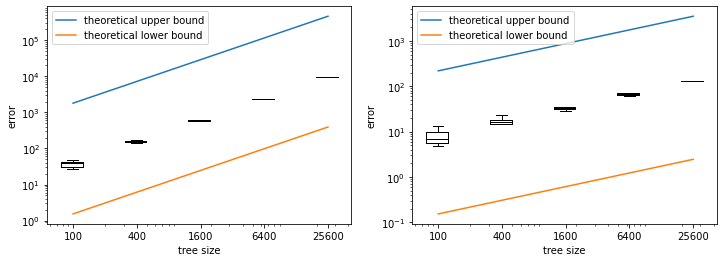

In [18]:
DATA=load_object("URRT_error.pickle")
R2,R2B,X=DATA[0],DATA[1],DATA[2]

fig = plt.figure(figsize=(12, 4))

positions=X

w = 0.2
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


ax = plt.subplot(1, 2, 1)

ax.boxplot(R2,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
ax.plot(X,[TheoreticalUpperBound(x,alpha) for x in X],label="theoretical upper bound")
#plt.xticks(X[:3])
if alpha>1:
    plt.plot(X,(1/65)*np.array(X)**(2-alpha),label="theoretical lower bound")
else:
    plt.plot(X,(1/65)*np.array(X)**(2-alpha),label="theoretical lower bound")
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
plt.xticks(ticks=X,labels=X)
plt.xlabel('tree size')
plt.ylabel('error')






ax = plt.subplot(1, 2, 2)

ax.boxplot(R2B,positions=positions, widths=width(positions,w), sym='',medianprops=dict(color="black"))
plt.plot(X,[TheoreticalUpperBound(x,alphaB) for x in X],label="theoretical upper bound")
if alphaB>1:
    plt.plot(X,(1/65)*np.array(X)**(2-alphaB),label="theoretical lower bound")
else:
    plt.plot(X,(1/65)*np.array(X)**(2-alphaB),label="theoretical lower bound")
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
plt.xticks(ticks=X,labels=X)
plt.xlabel('tree size')
plt.ylabel('error')


plt.show()

PA case:

In [19]:
alpha=1 # parameter of the error
alphaB=1.2 #second alpha in the simulation
n0=500 #initial size of the graph
n=1200 #max size of the graph
#step=100 #do not look at all sizes, but go with big steps
k=20 #number of experience for each size

In [30]:
R2=[]   # list of estimated error2
R2B=[]   # list of estimated error2 for alphaB
X=[]     # list of sizes of graph that we tried

i=n0
while i <n: #exponential steps
#for i in range(n0,n,step): #linear steps
    X.append(i)
    r2=[]
    r2B=[]
    for j in range(k):     # we do k experiments at each size
        M,ST=PA_subtree(i)   # we sample a URRT and the list of descendents of each vertex
        Ordering=ordering(ST)
        r2.append(error2(Ordering,alpha))
        r2B.append(error2(Ordering,alphaB))
    R2.append(r2)
    R2B.append(r2B)
    i=int(1.2*i) # update i
    
save_object([R2,R2B,X],"PA_error")

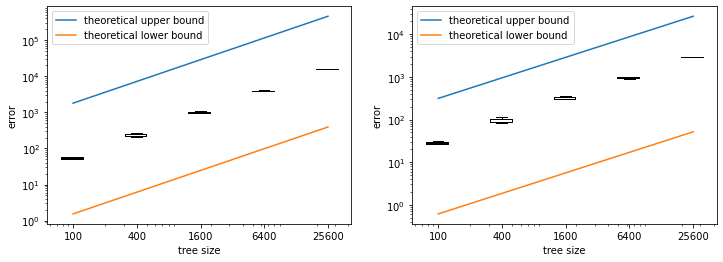

In [20]:
DATA=load_object("PA_error.pickle")
R2,R2B,X=DATA[0],DATA[1],DATA[2]

fig = plt.figure(figsize=(12, 4))

positions=X

w = 0.2
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


ax = plt.subplot(1, 2, 1)

ax.boxplot(R2,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
ax.plot(X,[TheoreticalUpperBound(x,alpha) for x in X],label="theoretical upper bound")
if alpha>1:
    plt.plot(X,(1/65)*np.array(X)**(2-alpha),label="theoretical lower bound")
else:
    plt.plot(X,(1/65)*np.array(X)**(2-alpha),label="theoretical lower bound")
ax.set_yscale('log')
ax.set_xscale('log')

#plt.xticks(ticks=X,labels=X)
plt.legend()
plt.xticks(ticks=X,labels=X)
plt.xlabel('tree size')
plt.ylabel('error')






ax = plt.subplot(1, 2, 2)

ax.boxplot(R2B,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,[TheoreticalUpperBound(x,alphaB) for x in X],label="theoretical upper bound")
if alphaB>1:
    plt.plot(X,(1/65)*np.array(X)**(2-alphaB),label="theoretical lower bound")
else:
    plt.plot(X,(1/65)*np.array(X)**(2-alphaB),label="theoretical upper bound")
ax.set_yscale('log')
ax.set_xscale('log')

#plt.xticks(ticks=X,labels=X)
plt.legend()
plt.xticks(ticks=X,labels=X)
plt.xlabel('tree size')
plt.ylabel('error')


plt.show()

## Comparison of different ordering methods in the URRT case

In [21]:
alpha=1.5   # parameter of the error
n0=62 #initial size of the graph
n=500 #max size of the graph
step=100 #do not look at all sizes, but go with big steps
k=20 #number of experience for each size

In [44]:
R2S=[]   # list of estimated error2 of spectral ordering

R2=[]   # list of estimated error2 for descendent ordering


R2D=[]    #list of estimated error2 of degree ordering
X=[]     # list of sizes of graph

i=n0
while i <n: #exponential steps
#for i in range(n0,n,step): #linear steps
    X.append(i)
    r2=[]
    r2S=[]
    r2D=[]
    for j in range(k):     # we do k experiments at each size
        M,ST=URRT_subtree(i)   # we sample a URRT
        m,D=URRTDegree(i)
        r2S.append(error2(SpectralOrdering(M),alpha))
        r2.append(error2(JordanOrdering(M),alpha))
        r2D.append(error2(DegreeOrdering(D),alpha))
    R2S.append(r2S)    
    R2.append(r2)
    R2D.append(r2D)
    i=int(2*i)
    
save_object([R2,R2S,R2D,X],"URRT_comparison")

KeyboardInterrupt: 

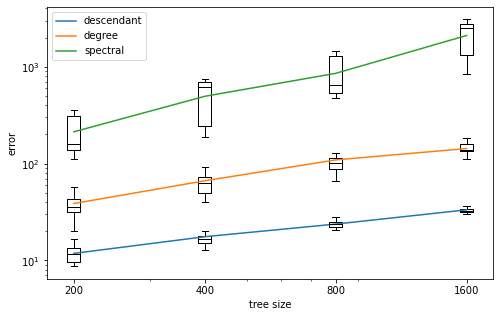

In [22]:
DATA=load_object("URRT_comparison.pickle")
R2,R2S,R2D,X=DATA[2],DATA[0],DATA[1],DATA[3]


R2m=[mean(r) for r in R2]   #mean of the realizations
R2Sm=[mean(r) for r in R2S]
R2Dm=[mean(r) for r in R2D]


fig=plt.figure(figsize=(8,5))

positions=X

w = 0.03
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


ax = plt.subplot(1, 1, 1)




ax.boxplot(R2,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,R2m,label="descendant")

ax.boxplot(R2D,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,R2Dm,label="degree")

ax.boxplot(R2S,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,R2Sm,label="spectral")

ax.set_yscale('log')
ax.set_xscale('log')

plt.xticks(ticks=X,labels=X)
plt.legend()
plt.xlabel('tree size')
plt.ylabel('error')


plt.show()

# Comparison of errors for PA 

In [23]:
alpha=1.2  # parameter of the error
n0=124 #initial size of the graph
n=1000 #max size of the graph
n2=251 #max size of peeling
step=20 #do not look at all sizes, but go with big steps
k=20 #number of experience for each size

In [52]:



R2S=[]   # list of estimated error2 of spectral ordering
R2=[]   # list of estimated error2 of descendant ordering
R2D=[]    #list of error 2 of degree ordering
R2IP=[]   # list of estimated error2 of Improved Peeling ordering
X=[]     # list of sizes of graph that we tried
X2=[]    #list of sizes we tried for the Peeling method (we stop earlier)

i=n0
while i <n: #exponential steps
#for i in range(n0,n,step): #linear steps
    
    X.append(i)
    if i<n2:
        X2.append(i)

    r2=[]
    r2S=[]
    r2D=[]
    r2IP=[]
    for j in range(k):     # we do k experiments at each size
        M,ST=PA_subtree(i)   # we sample a PA
        m,D=PADegree(i)
        r2S.append(error2(SpectralOrdering(M),alpha))
        r2D.append(error2(DegreeOrdering(D),alpha))
        r2.append(error2(JordanOrdering(M),alpha))
        if i < n2:
            r2IP.append(error2(ImprovedPeeling(M),alpha))
        
        
    R2S.append(r2S)    
    R2.append(r2)
    R2D.append(r2D)

    if i < n2:
        R2IP.append(r2IP)
    i=int(2*i)
    
save_object([R2,R2S,R2D,R2IP,X,X2],"PA_comparison")

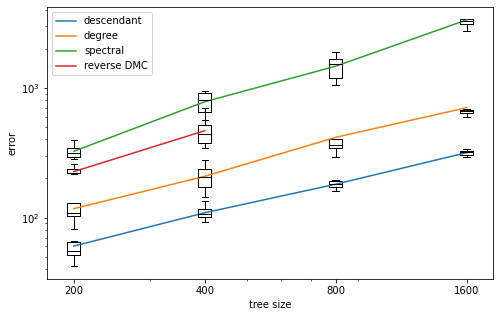

In [24]:
DATA=load_object("PA_comparison.pickle")
R2,R2S,R2D,R2IP,X,X2=DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5]

R2m=[mean(r) for r in R2]   #mean of the realizations
R2Sm=[mean(r) for r in R2S]
R2Dm=[mean(r) for r in R2D]
R2IPm=[mean(r) for r in R2IP]


fig=plt.figure(figsize=(8,5))

positions=X
positions2=X2

w = 0.03
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


ax = plt.subplot(1, 1, 1)



ax.boxplot(R2,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,R2m,label="descendant")

ax.boxplot(R2D,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,R2Dm,label="degree")

ax.boxplot(R2S,positions=positions, widths=width(positions,w),sym='',medianprops=dict(color="black"))
plt.plot(X,R2Sm,label="spectral")

ax.boxplot(R2IP,positions=positions2, widths=width(positions2,w),sym='',medianprops=dict(color="black"))
plt.plot(X2,R2IPm,label="reverse DMC")

ax.set_yscale('log')
ax.set_xscale('log')

plt.xticks(ticks=X,labels=X)
plt.legend()
plt.xlabel('tree size')
plt.ylabel('error')


plt.show()

## Estimation of performances for degree ordering

In [18]:
from sklearn.linear_model import LinearRegression

PA case:

In [25]:
n0=1000 #initial size of the graph
n=8001 #max size of the graph
k=10 #number of experience for each size
ALPHA=np.linspace(1,1.25,10) #liste des alpha à tester

In [33]:
SLOPE=[]
R=[]
R2D=[]
X=[]

i=n0

while i<n:
    r2D=np.zeros(10)
    X.append(i)
    for j in range(k):     # we do k experiments at each size
        m,D=PADegree(i)    #sample a PA
        SolvedOrdering=DegreeOrdering(D)
        for j in range(10):
            alpha=ALPHA[j]
            r2D[j]+=error2(SolvedOrdering,alpha)
    r2D=r2D/k
    R2D.append(r2D)
    i=int(2*i)
    
R2D=np.matrix(R2D)

for j in range(10):
    y = np.log(np.array(R2D[:,j]))
    x = np.log(np.array(X)).reshape((-1, 1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    slope=model.coef_[0]
    R.append(r_sq)
    SLOPE.append(slope)
    
save_object([SLOPE,R],"PA_Degree_Slope")

In [31]:
SLOPE=[]
R=[]
R2D=[]
X=[]

i=n0

while i<n:
    r2D=np.zeros(10)
    X.append(i)
    for j in range(k):     # we do k experiments at each size
        m,ST=PA_subtree(i)    #sample a PA
        SolvedOrdering=ordering(ST)
        for j in range(10):
            alpha=ALPHA[j]
            r2D[j]+=error2(SolvedOrdering,alpha)
    r2D=r2D/k
    R2D.append(r2D)
    i=int(2*i)
    
R2D=np.matrix(R2D)

for j in range(10):
    y = np.log(np.array(R2D[:,j]))
    x = np.log(np.array(X)).reshape((-1, 1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    slope=model.coef_[0]
    R.append(r_sq)
    SLOPE.append(slope)
    
save_object([SLOPE,R,X],"PA_Jordan_Slope")

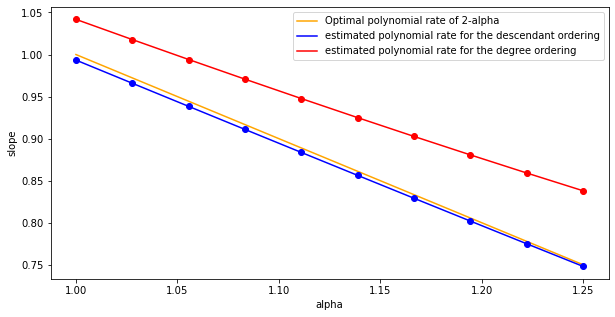

In [26]:
DATA=load_object("PA_Jordan_Slope.pickle")
SLOPEJ,RJ,X=DATA[0],DATA[1],DATA[2]
DATA1=load_object("PA_Degree_Slope.pickle")
SLOPED,RD=DATA1[0],DATA1[1]


fig=plt.figure(figsize=(10,5))

plt.plot(ALPHA,2-ALPHA,label="Optimal polynomial rate of 2-alpha",color='orange')
plt.plot(ALPHA,SLOPEJ,label="estimated polynomial rate for the descendant ordering",color='blue')
plt.plot(ALPHA,SLOPED,label="estimated polynomial rate for the degree ordering",color='red')
plt.plot(ALPHA,SLOPEJ,'o',color='blue')
plt.plot(ALPHA,SLOPED,'o',color='red')
plt.xlabel('alpha')
plt.ylabel('slope')
plt.legend()
plt.show()

URRT case:

In [27]:
n0=500 #initial size of the graph
n=4001 #max size of the graph
k=10 #number of experience for each size
ALPHA=np.linspace(1,1.9,10)

In [182]:
SLOPE=[]
R=[]
R2D=[]
X=[]

i=n0

while i<n:
    r2D=np.zeros(10)
    X.append(i)
    for j in range(k):     # we do k experiments at each size
        m,D=URRTDegree(i)    #sample a URRT
        SolvedOrdering=DegreeOrdering(D)
        for j in range(10):
            alpha=ALPHA[j]
            r2D[j]+=error2(SolvedOrdering,alpha)
    r2D=r2D/k
    R2D.append(r2D)
    i=int(2*i)
    
R2D=np.matrix(R2D)

for j in range(10):
    y = np.log(np.array(R2D[:,j]))
    x = np.log(np.array(X)).reshape((-1, 1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    slope=model.coef_[0]
    R.append(r_sq)
    SLOPE.append(slope)
    
save_object([SLOPE,R],"URRT_Degree_Slope")

In [ ]:
SLOPE=[]
R=[]
R2D=[]
X=[]

i=n0

while i<n:
    r2D=np.zeros(10)
    X.append(i)
    for j in range(k):     # we do k experiments at each size
        m,ST=URRT_subtree(i)    #sample a PA
        SolvedOrdering=ordering(ST)
        for j in range(10):
            alpha=ALPHA[j]
            r2D[j]+=error2(SolvedOrdering,alpha)
    r2D=r2D/k
    R2D.append(r2D)
    i=int(2*i)
    
R2D=np.matrix(R2D)

for j in range(10):
    y = np.log(np.array(R2D[:,j]))
    x = np.log(np.array(X)).reshape((-1, 1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    slope=model.coef_[0]
    R.append(r_sq)
    SLOPE.append(slope)
    
save_object([SLOPE,R,X],"URRT_Jordan_Slope")

In [28]:
DATA=load_object("URRT_Jordan_Slope.pickle")
SLOPEJ,RJ,X=DATA[0],DATA[1],DATA[2]
DATA1=load_object("URRT_Degree_Slope.pickle")
SLOPED,RD=DATA1[0],DATA1[1]


fig=plt.figure(figsize=(10,5))

plt.plot(ALPHA,2-ALPHA,label="Optimal polynomial rate of 2-alpha",color='orange')
plt.plot(ALPHA,SLOPEJ,label="Estimated polynomial rate for the descendant ordering",color='blue')
plt.plot(ALPHA,SLOPED,label="Estimated polynomial rate for the degree ordering",color='red')
plt.plot(ALPHA,SLOPEJ,'o',color='blue')
plt.plot(ALPHA,SLOPED,'o',color='red')
plt.xlabel('alpha')
plt.ylabel('slope')
plt.legend()
plt.show()

Error during unpickling object (Possibly unsupported): [Errno 2] No such file or directory: 'URRT_Jordan_Slope.pickle'


TypeError: 'NoneType' object is not subscriptable